<a href="https://colab.research.google.com/github/AlbTchik/SynPaFlex_Test-To-Speech_Synthesis/blob/main/Text_To_Speech_Synpaflex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation of TensorFlowTTS and requirements

In [1]:
import os
os.system("rm -rf TensorFlowTTS")
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git
os.chdir("TensorFlowTTS")
!pip install .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

Cloning into 'TensorFlowTTS'...
remote: Enumerating objects: 10679, done.
remote: Total 10679 (delta 0), reused 0 (delta 0), pack-reused 10679
Receiving objects: 100% (10679/10679), 133.52 MiB | 25.82 MiB/s, done.
Resolving deltas: 100% (5163/5163), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/TensorFlowTTS
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 489.6 MB 20 kB/s 
     |████████████████████████████████| 1.1 MB 60.6 MB/s 
     |████████████████████████████████| 235 kB 44.0 MB/s 
     |████████████████████████████████| 2

In [2]:
!pip install git+https://github.com/repodiac/german_transliterate.git#egg=german_transliterate
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/repodiac/german_transliterate.git to /tmp/pip-install-cs3q97ji/german-transliterate_6cad88bccec345e5825744b7dfec12bf
  Running command git clone -q https://github.com/repodiac/german_transliterate.git /tmp/pip-install-cs3q97ji/german-transliterate_6cad88bccec345e5825744b7dfec12bf
     |████████████████████████████████| 101 kB 4.6 MB/s 
  Created wheel for german-transliterate: filename=german_transliterate-0.1.3-py3-none-any.whl size=20829 sha256=da04e3bb8cb84a2c2caca4e18b51c96dd5b664037ac29f9e50a06d222751b658
  Stored in directory: /tmp/pip-ephem-wheel-cache-fte3mtpl/wheels/77/17/55/6c6d2d33bd2b3b8a3741e12b17f0b18278861f64858bbcc228
Successfully built german-transliterate
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 10.7 MB/s 
  Attempting uninstall: h5py
    

## Load Model

In [3]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


## Pre-trained Tacotron2

In [4]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-synpaflex-fr", name="tacotron2")

Downloading:   0%|          | 0.00/128M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

## MB-MelGAN

In [5]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-synpaflex-fr", name="mb_melgan")

Downloading:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

## Inference

In [6]:
processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-synpaflex-fr")

Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

In [7]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MB-MELGAN":
    # tacotron-2 generate noise in the end symtematic, let remove it :v.
    if text2mel_name == "TACOTRON":
      remove_end = 1024
    else:
      remove_end = 1
    audio = vocoder_model.inference(mel_outputs)[0, :-remove_end, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [8]:
input_text = "Oh, je voudrais tant que tu te souviennes Des jours heureux quand nous étions amis"

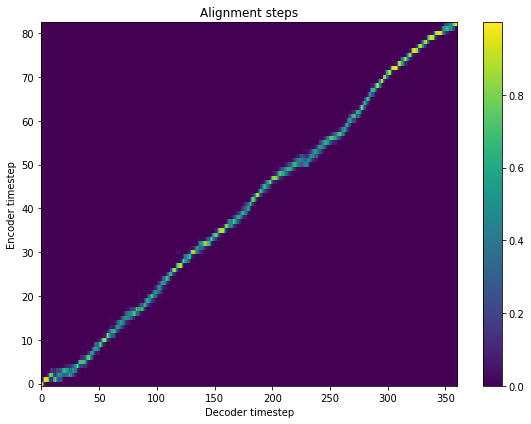

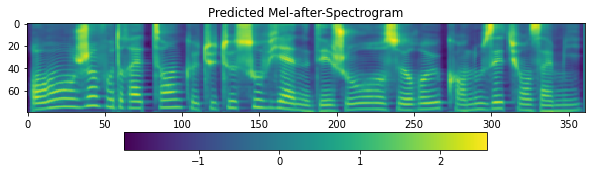

In [9]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=24000)